# Analysis and Comparison with Bone Marrow Dataset

## Load and pre-process the data with Scanpy

In [1]:
import scanpy as sc
from matplotlib import rcParams
import pyMuTrans as pm
sc.settings.set_figure_params(dpi=200, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

adata = sc.read_csv('marrow_sample_scseq_counts.csv.gz')
sc.pp.recipe_zheng17(adata)
adata

/Users/cliffzhou/opt/anaconda3/lib/python3.7/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.6.
  .format(latest=latest, current=current), category=UserWarning)


AnnData object with n_obs × n_vars = 4142 × 999
    obs: 'n_counts_all'
    var: 'n_counts', 'mean', 'std'
    uns: 'log1p'

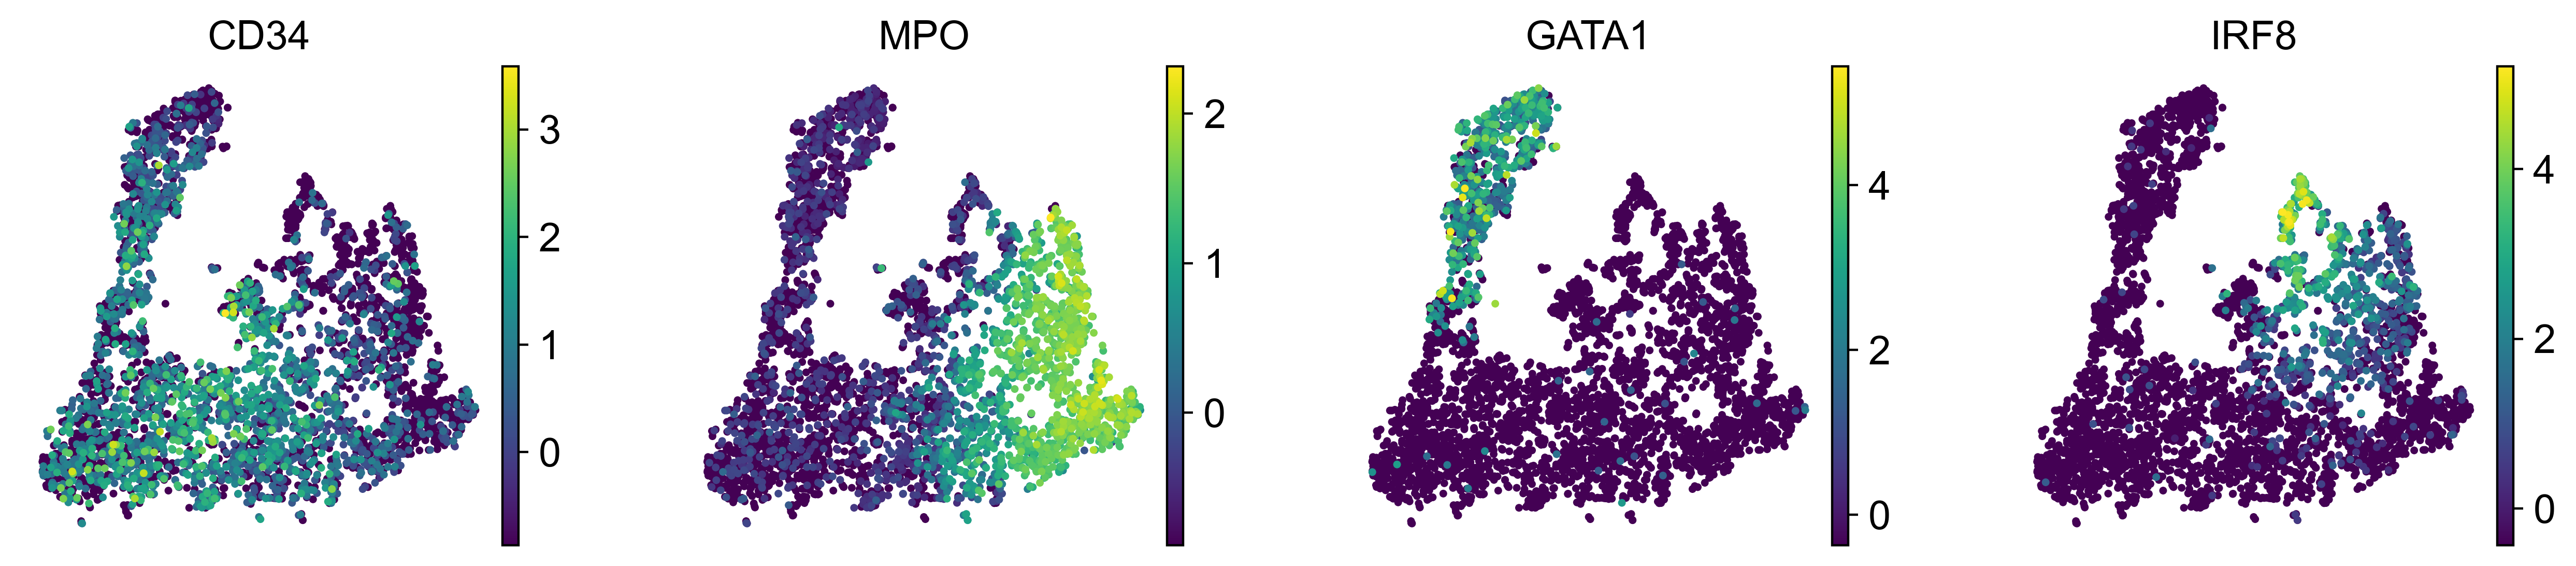

In [2]:
sc.tl.pca(adata, svd_solver='arpack')
sc.tl.tsne(adata, n_pcs=20)
fig = sc.pl.tsne(adata,color = ['CD34', 'MPO', 'GATA1', 'IRF8'],return_fig = True)

## PAGA Analysis

/Users/cliffzhou/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/cliffzhou/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/cliffzhou/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/cliffzhou/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories

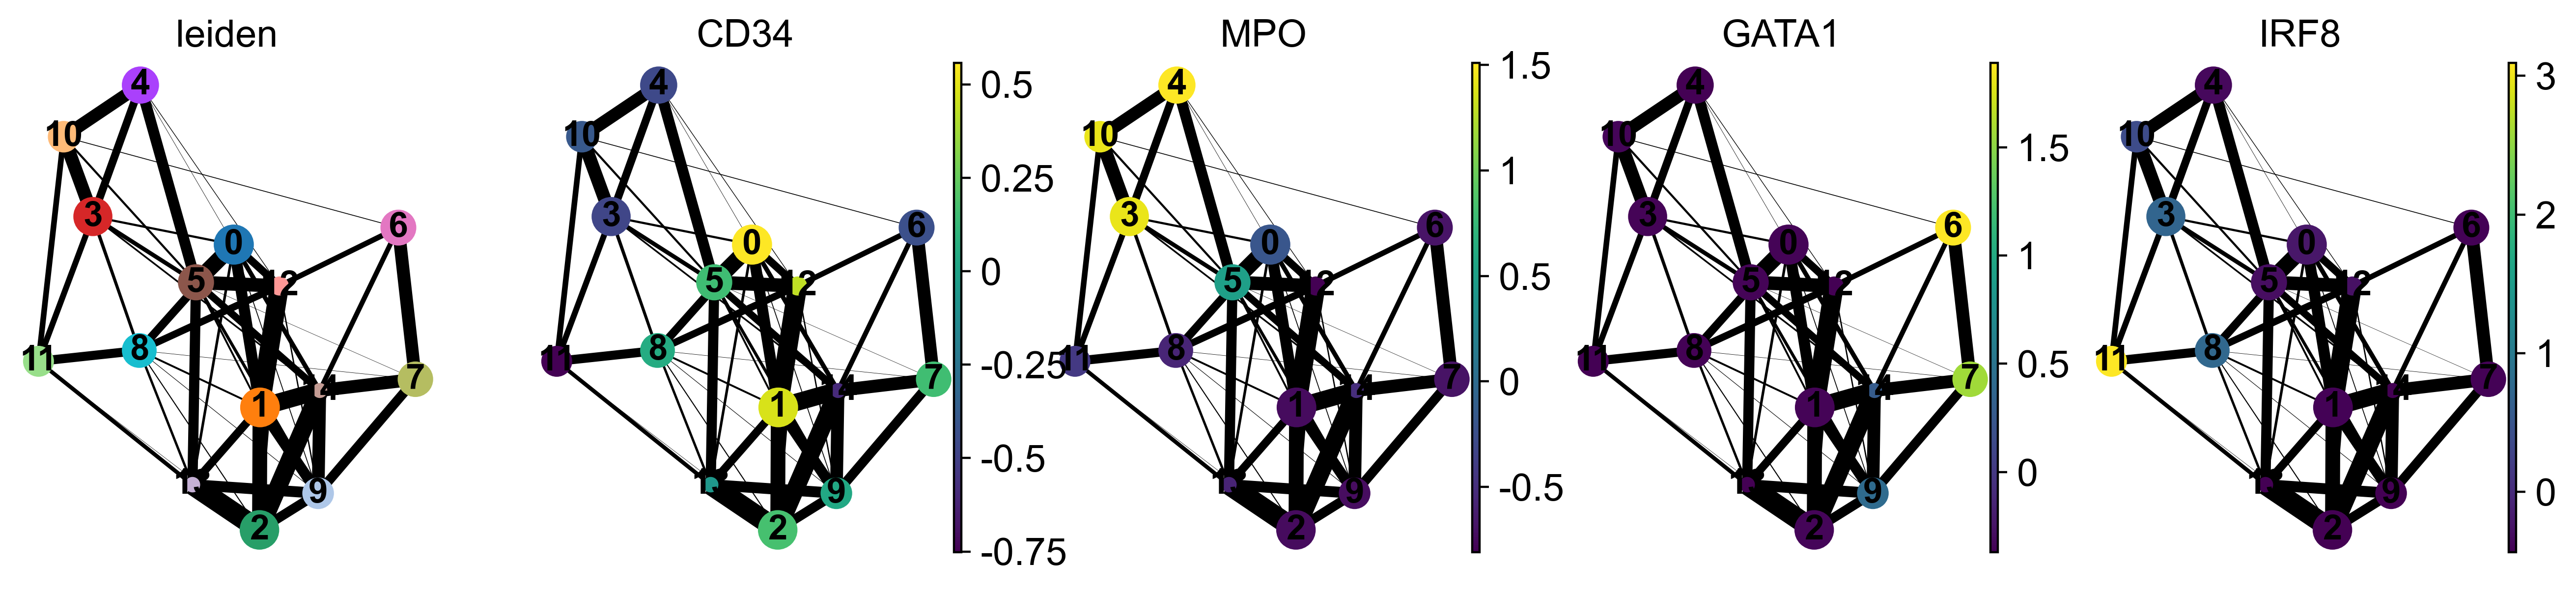

In [3]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.leiden(adata, resolution=1.0)
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, color=['leiden', 'CD34', 'MPO', 'GATA1', 'IRF8'])

## MuTrans Analysis with Finest Scale

In [4]:
%%time
par = {"choice_distance":"cosine","K_cluster":5.0,"trials":50,"weight_scale":True,"initial":"pca","reduce_large_scale":False} 
adata_complete = pm.dynamical_analysis(adata,par)

CPU times: user 3min 59s, sys: 5.1 s, total: 4min 5s
Wall time: 2h 11min 52s


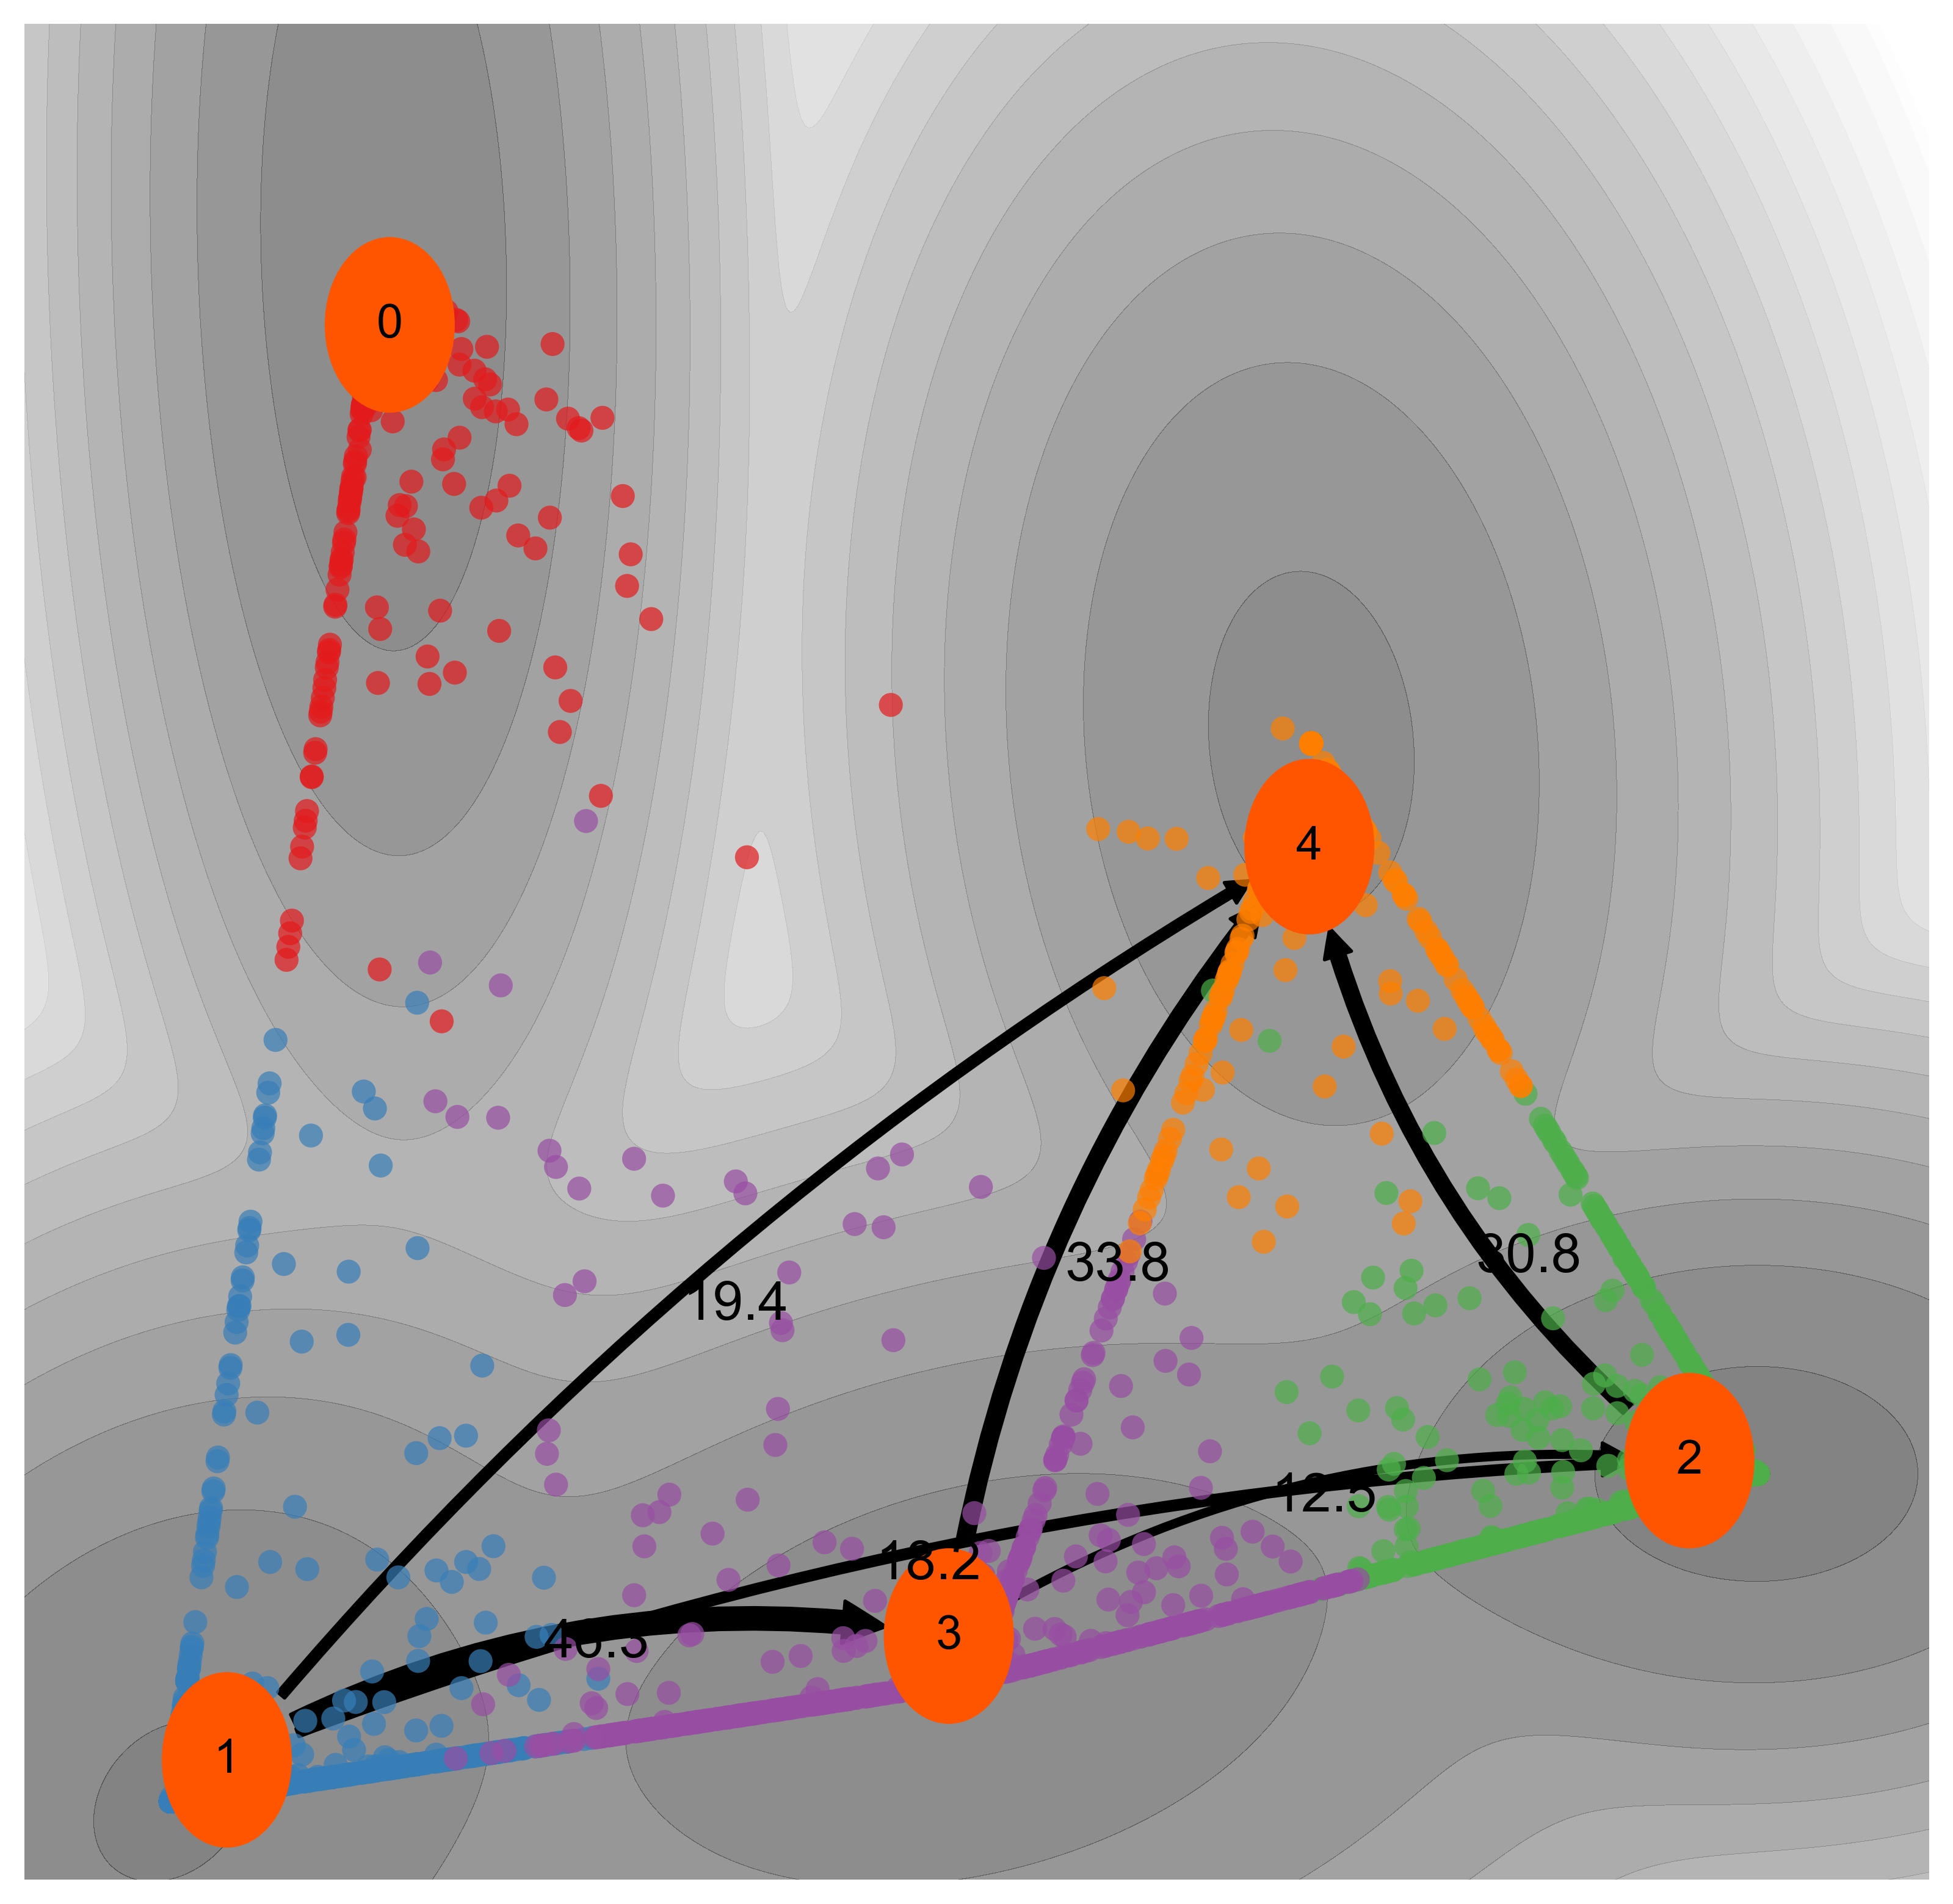

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10))
pm.infer_lineage(adata_complete,si=1,sf = 4,method = "MPPT",flux_fraction = 0.8,size_state = 0.2,size_text=16,alpha_point = 0.7)
fig.savefig('bm_whole_mppt_den.pdf')

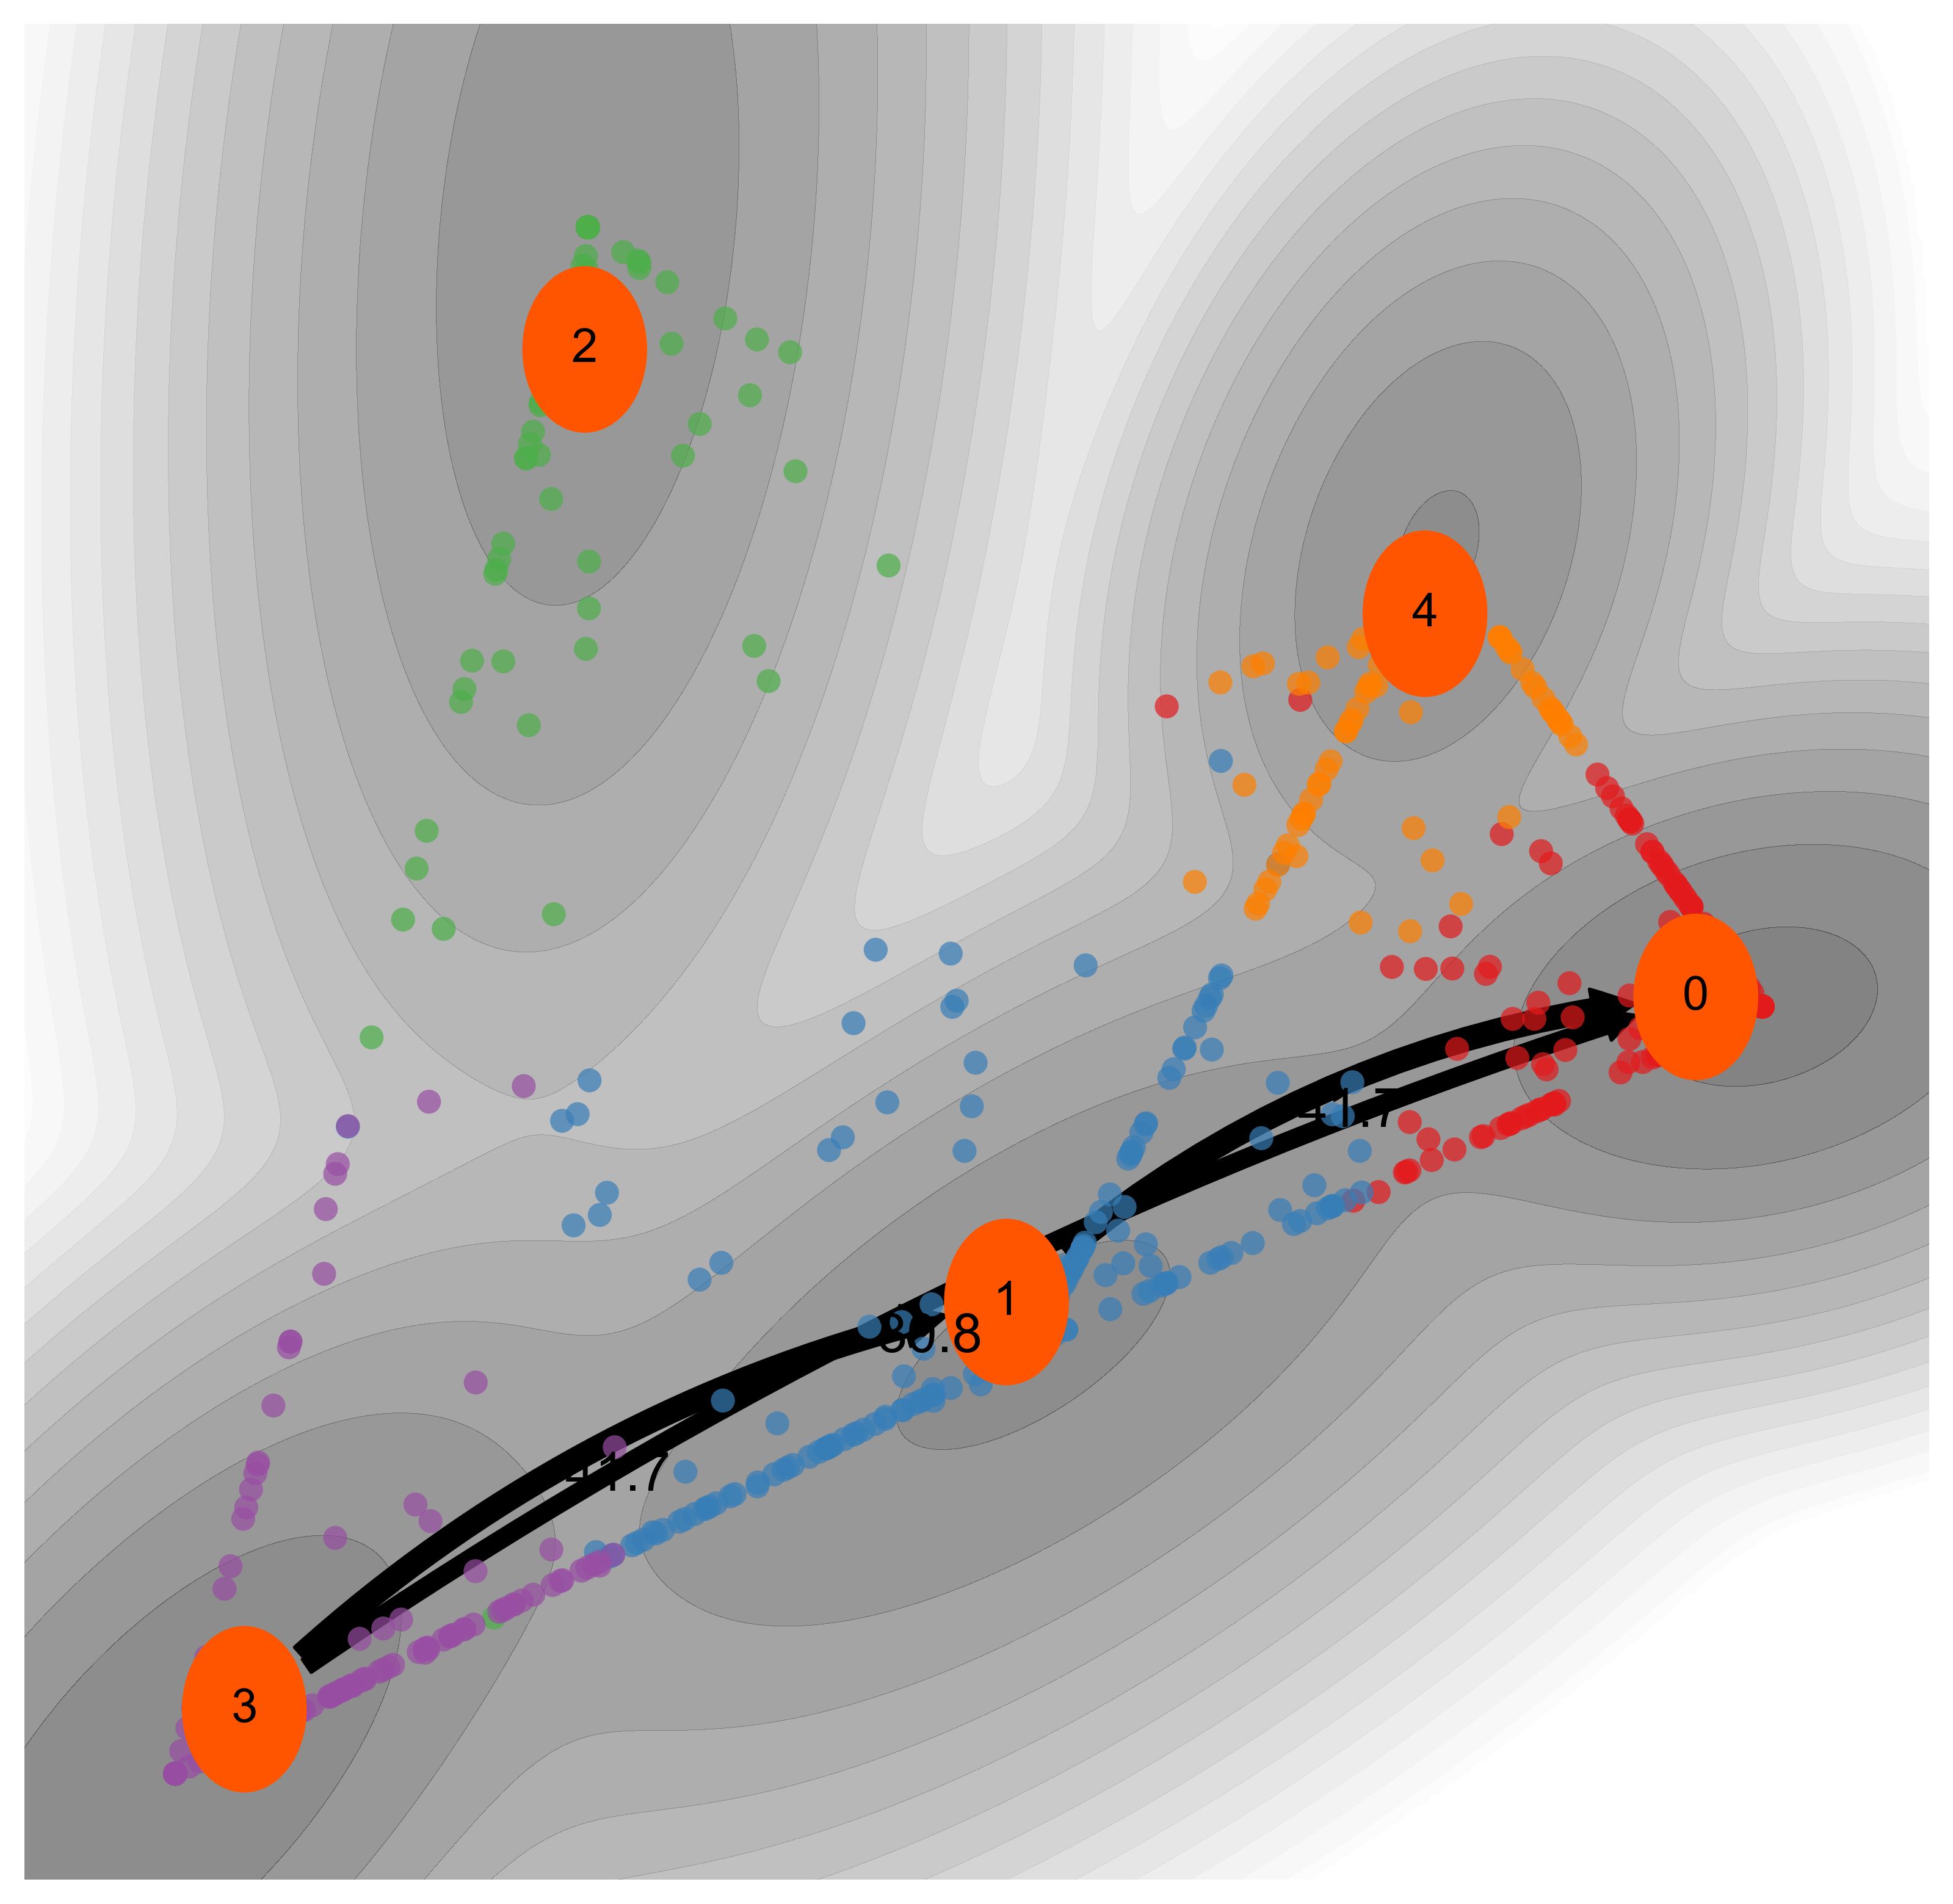

In [19]:
fig = plt.figure(figsize = (10,10))
pm.infer_lineage(adata_complete,si=3,sf = 0,method = "MPPT",flux_fraction = 0.7,size_state = 0.2,size_text=16,alpha_point = 0.7)
fig.savefig('bm_whole_mppt_mono.pdf')

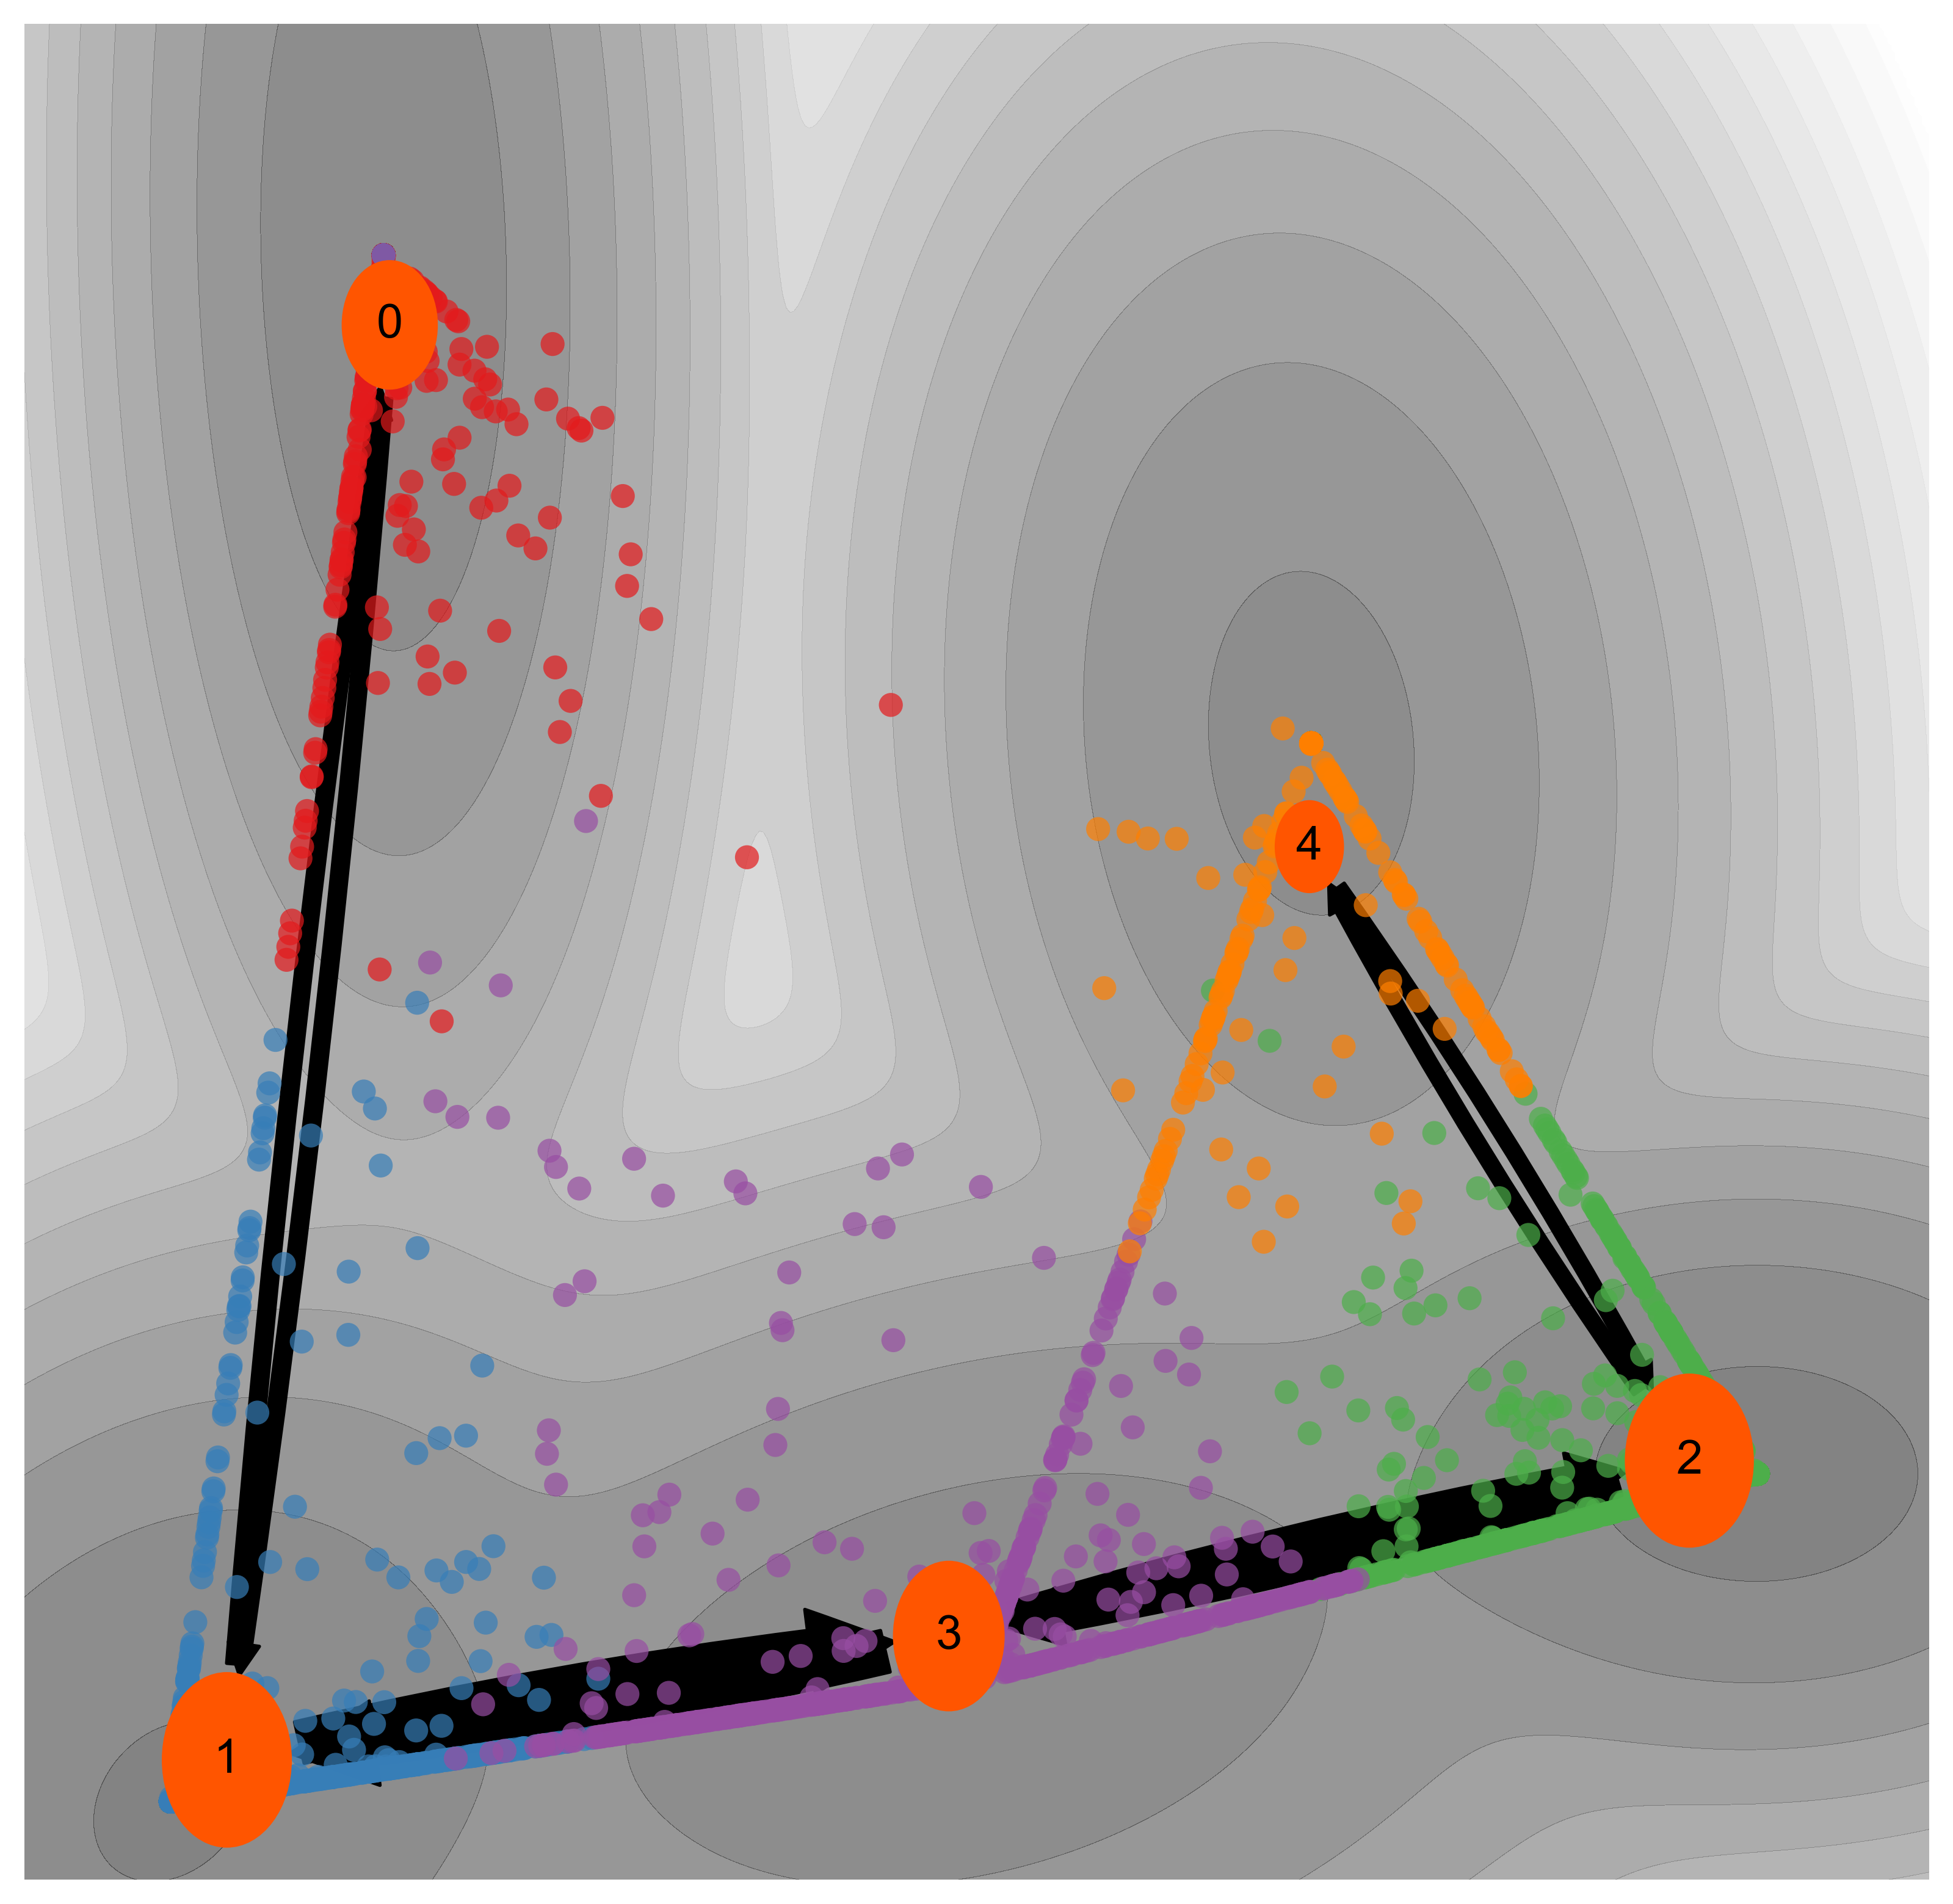

In [7]:
fig = plt.figure(figsize = (10,10))
pm.infer_lineage(adata_complete, method = "MPFT",size_state = 0.2,size_text=16,alpha_point = 0.7)
fig.savefig('bm_whole_mpft.pdf')

## MuTrans Analysis with Hierachical Multiscale Reduction (Recommended)

In [8]:
%%time
par = {"choice_distance":"cosine","K_cluster":5.0,"trials":50,"weight_scale":True,"initial":"pca","reduce_large_scale":True,"reduce_num_meta_cell":1200.0} 
adata_hmr = pm.dynamical_analysis(adata,par)


CPU times: user 51.7 s, sys: 977 ms, total: 52.7 s
Wall time: 4min 58s


The Most Probable Transiton Path from HSC to dendritic cells

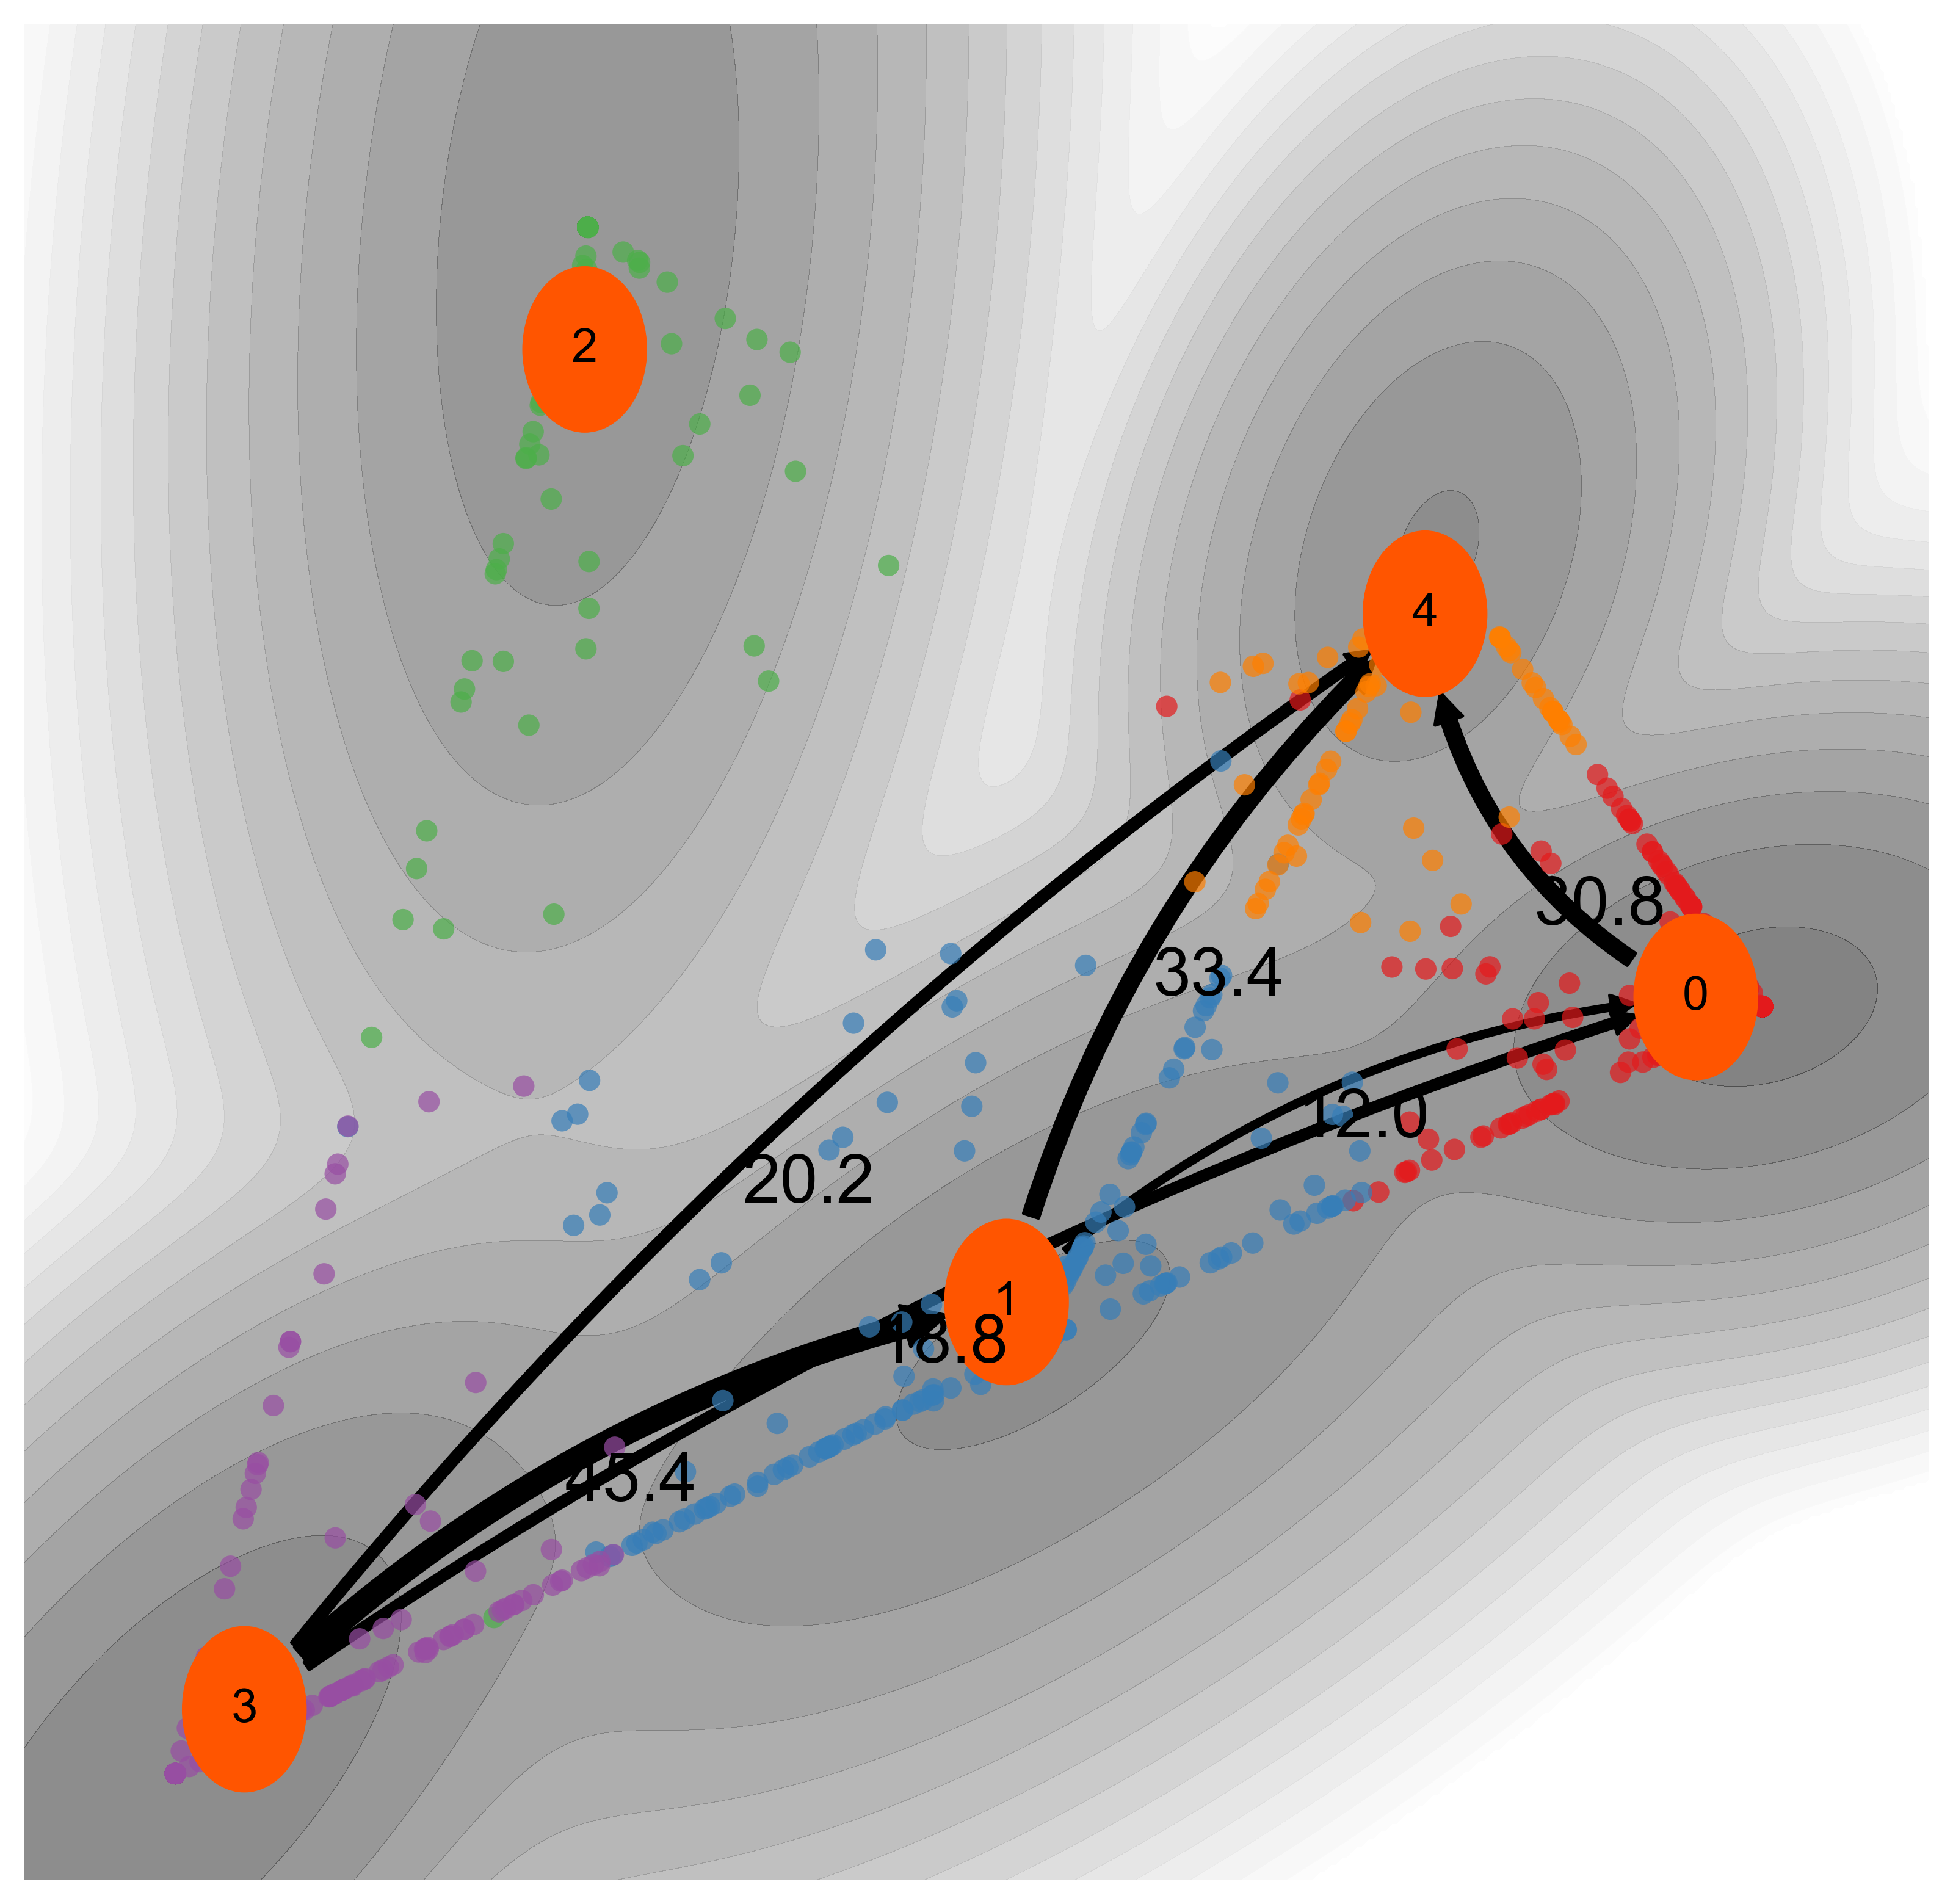

In [9]:
fig = plt.figure(figsize = (10,10))
pm.infer_lineage(adata_hmr,si=3,sf = 2,method = "MPPT",flux_fraction = 0.8,size_state = 0.2,size_point =40,size_text=20,alpha_point = 0.7)
fig.savefig('bm_reduction_mppt_dend.pdf')

The Most Probable Transiton Path from HSC to monocytic cells

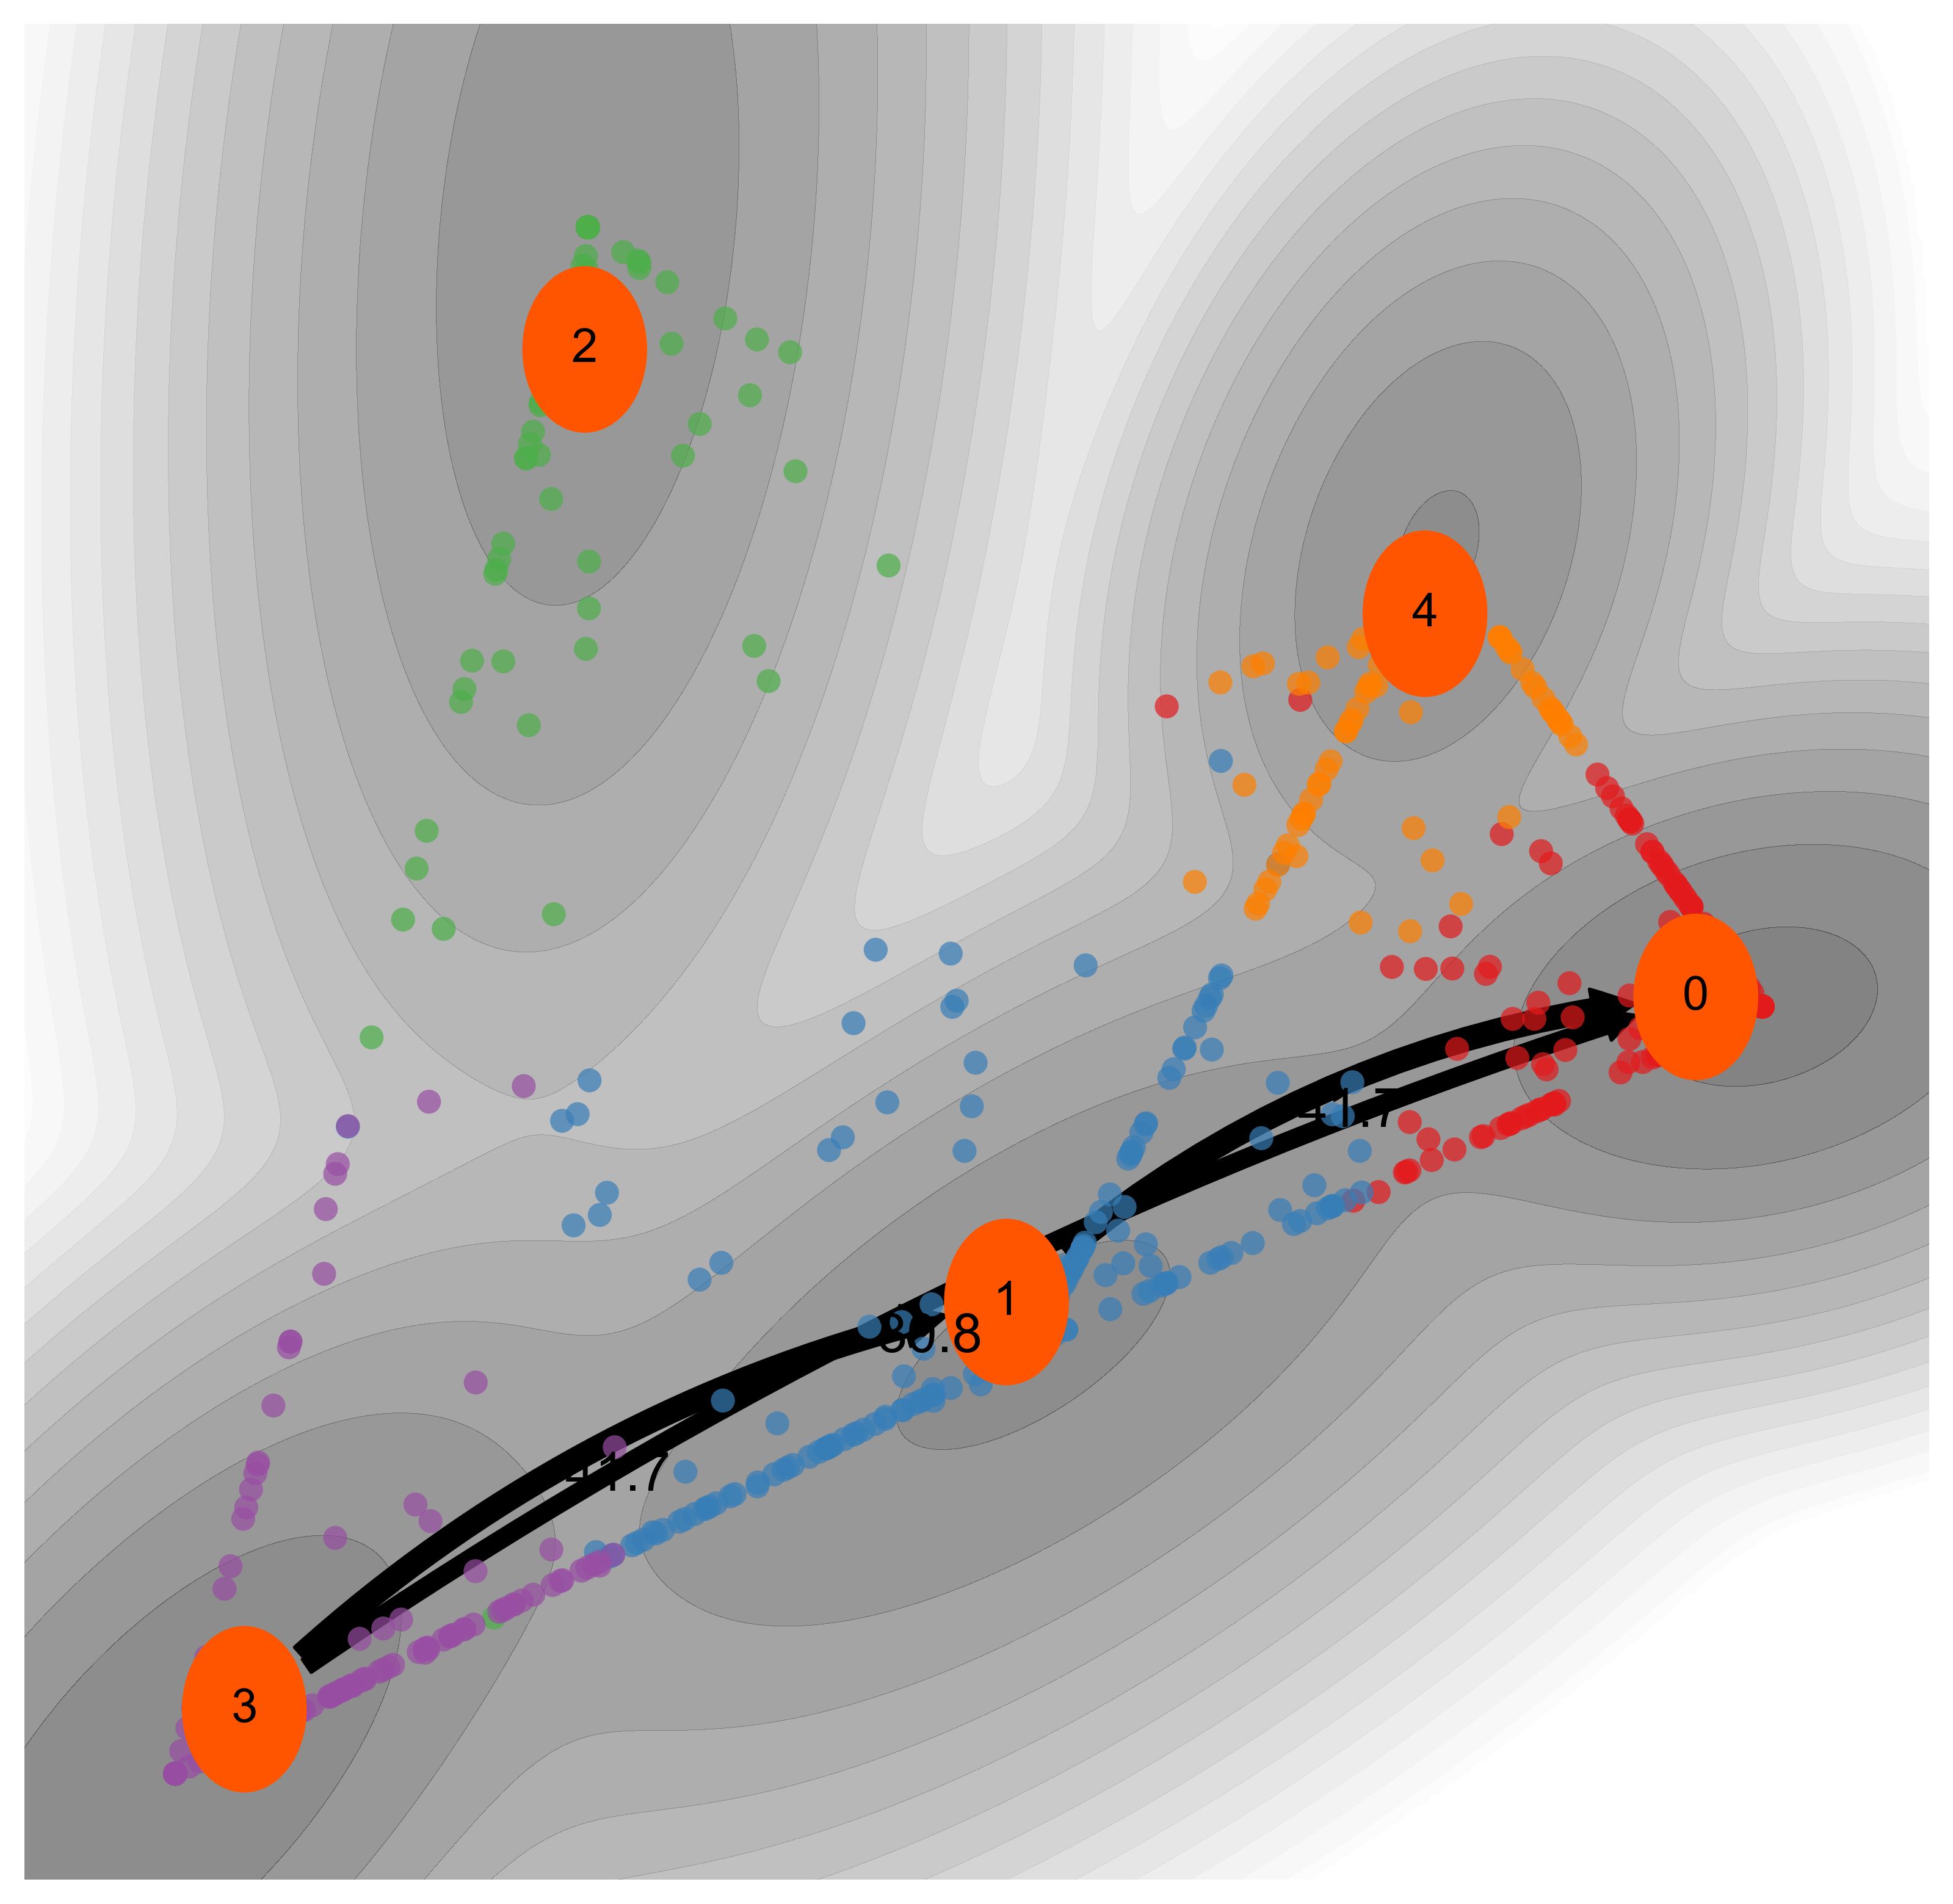

In [25]:
fig = plt.figure(figsize = (10,10))
pm.infer_lineage(adata_hmr,si=3,sf = 0,method = "MPPT",flux_fraction = 0.7,size_state = 0.2,size_text=16,alpha_point = 0.7)
fig.savefig('bm_whole_mppt_mono.pdf')

The overall lineage inferred by Maximum Path Flow Tree (MPFT)

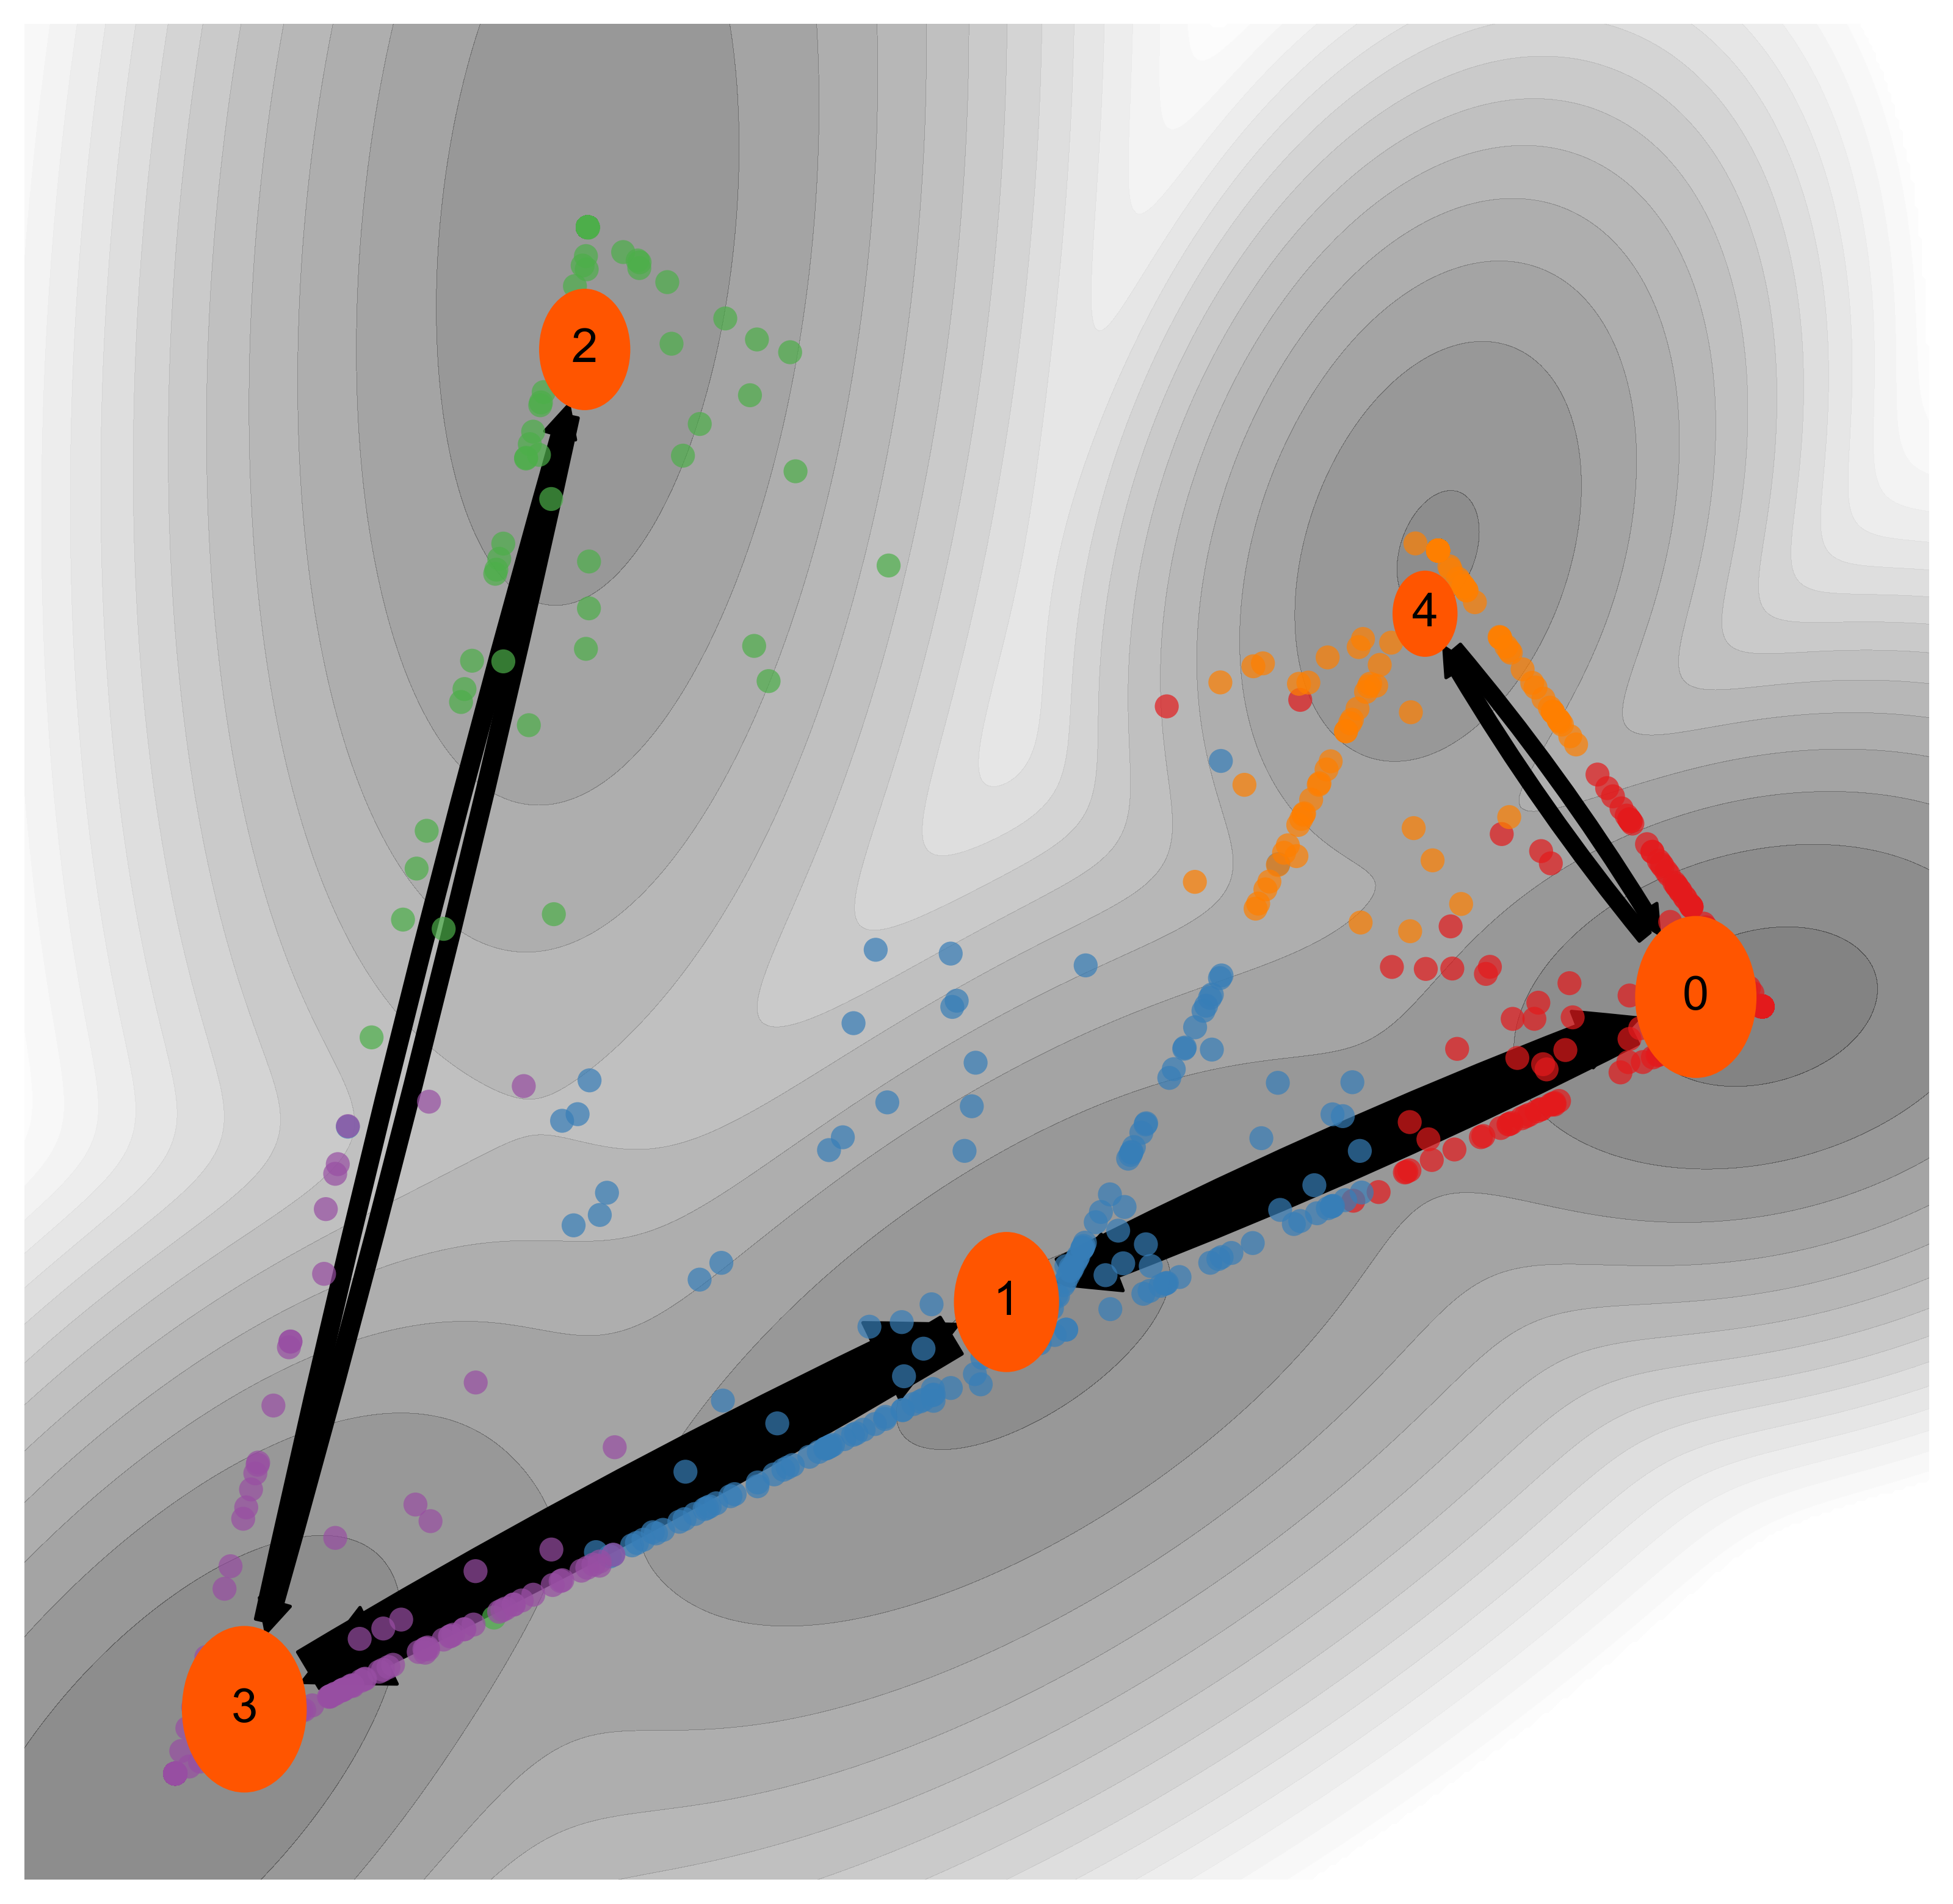

In [10]:
fig = plt.figure(figsize = (10,10))
pm.infer_lineage(adata_hmr, method = "MPFT",size_state = 0.2,size_text=16,alpha_point = 0.7)
fig.savefig('bm_reduction_mpft.pdf')

## Comparison with Another Meta-Cell Strategy

In [11]:
import numpy as np
data_meta = np.asarray(adata.uns['da_out']['data'])
reduce_class = np.asarray(adata.uns['da_out']['reduce_class'], dtype = 'int').reshape(-1)-1

In [12]:
coord = adata.obsm['X_tsne']
reduce_coord = np.zeros((data_meta.shape[0],2))
for i in range(np.max(reduce_class)+1):
    reduce_coord[i,:] = np.mean(coord[reduce_class==i,:],axis = 0) 
reduce_coord   

adata_meta = sc.AnnData (X = data_meta)
adata_meta.obsm['X_tsne'] = reduce_coord

In [13]:
par = {"choice_distance":"cosine","K_cluster":5.0,"trials":50,"weight_scale":True,"initial":"pca"} 
adata_meta = pm.dynamical_analysis(adata_meta,par)

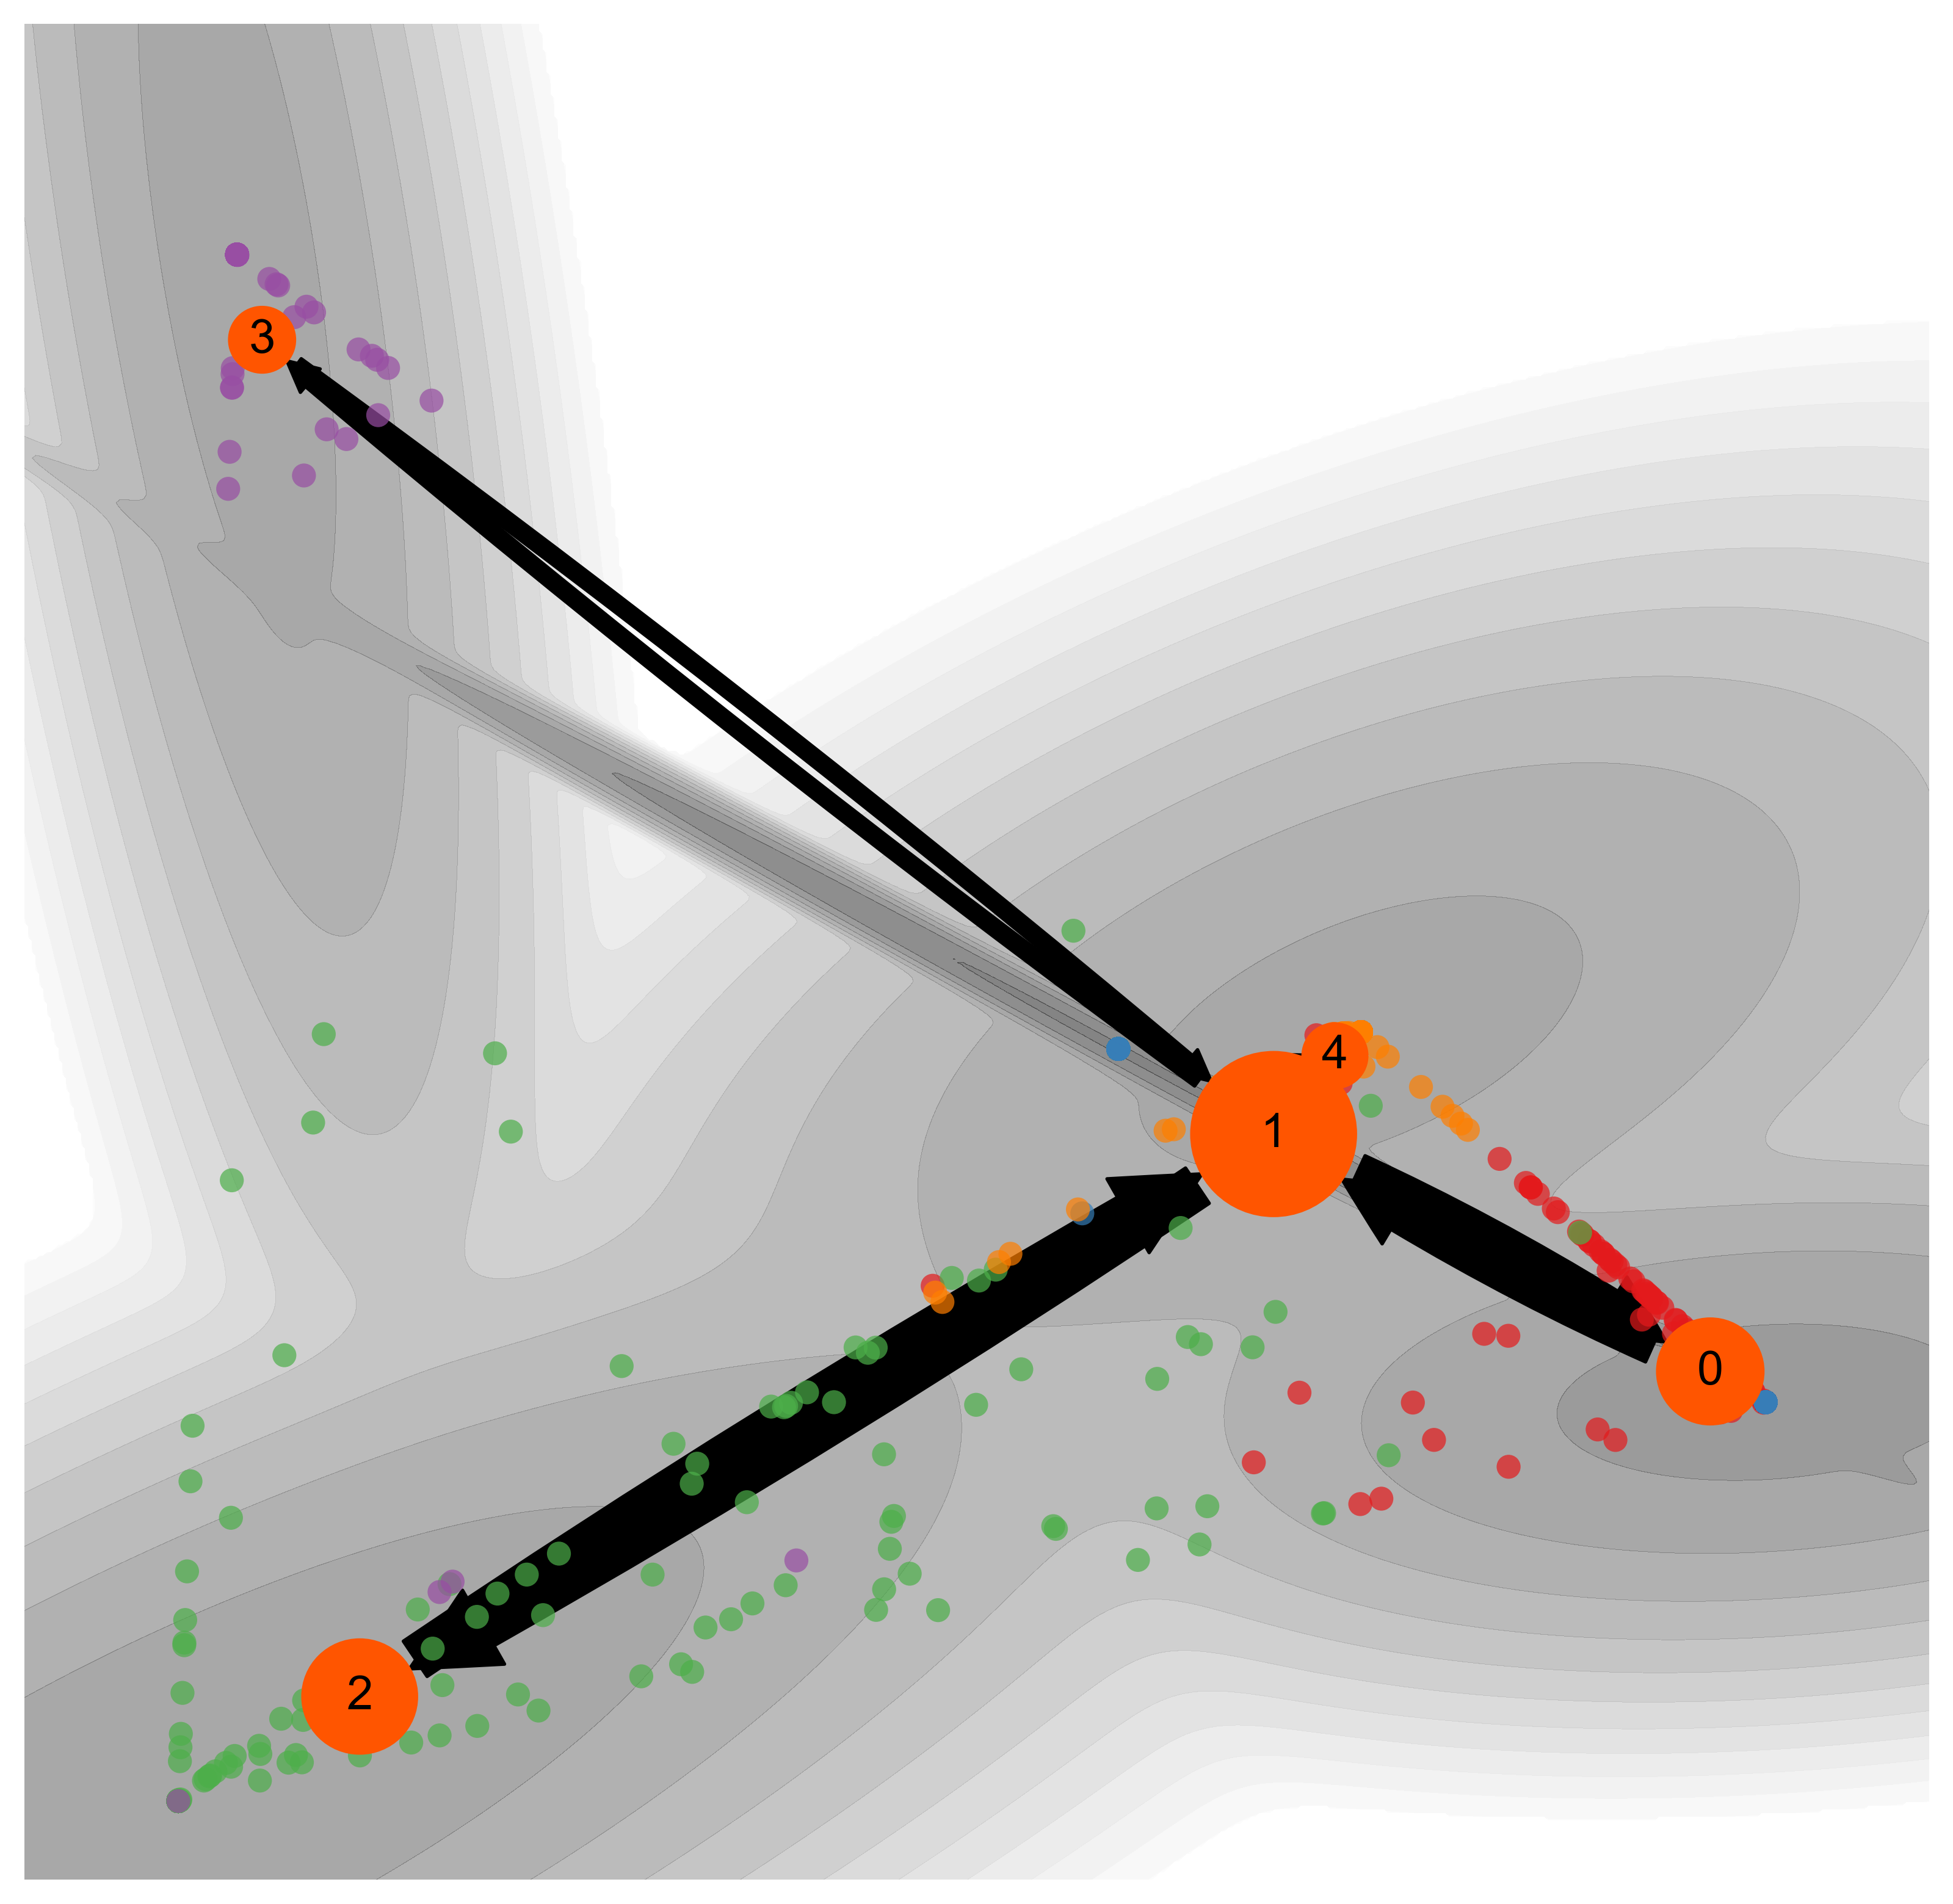

In [24]:
fig = plt.figure(figsize = (10,10))
pm.infer_lineage(adata_meta, method = "MPFT",size_state = 0.2,size_text=16,alpha_point = 0.7)
fig.savefig('bm_meta_mpft.pdf')

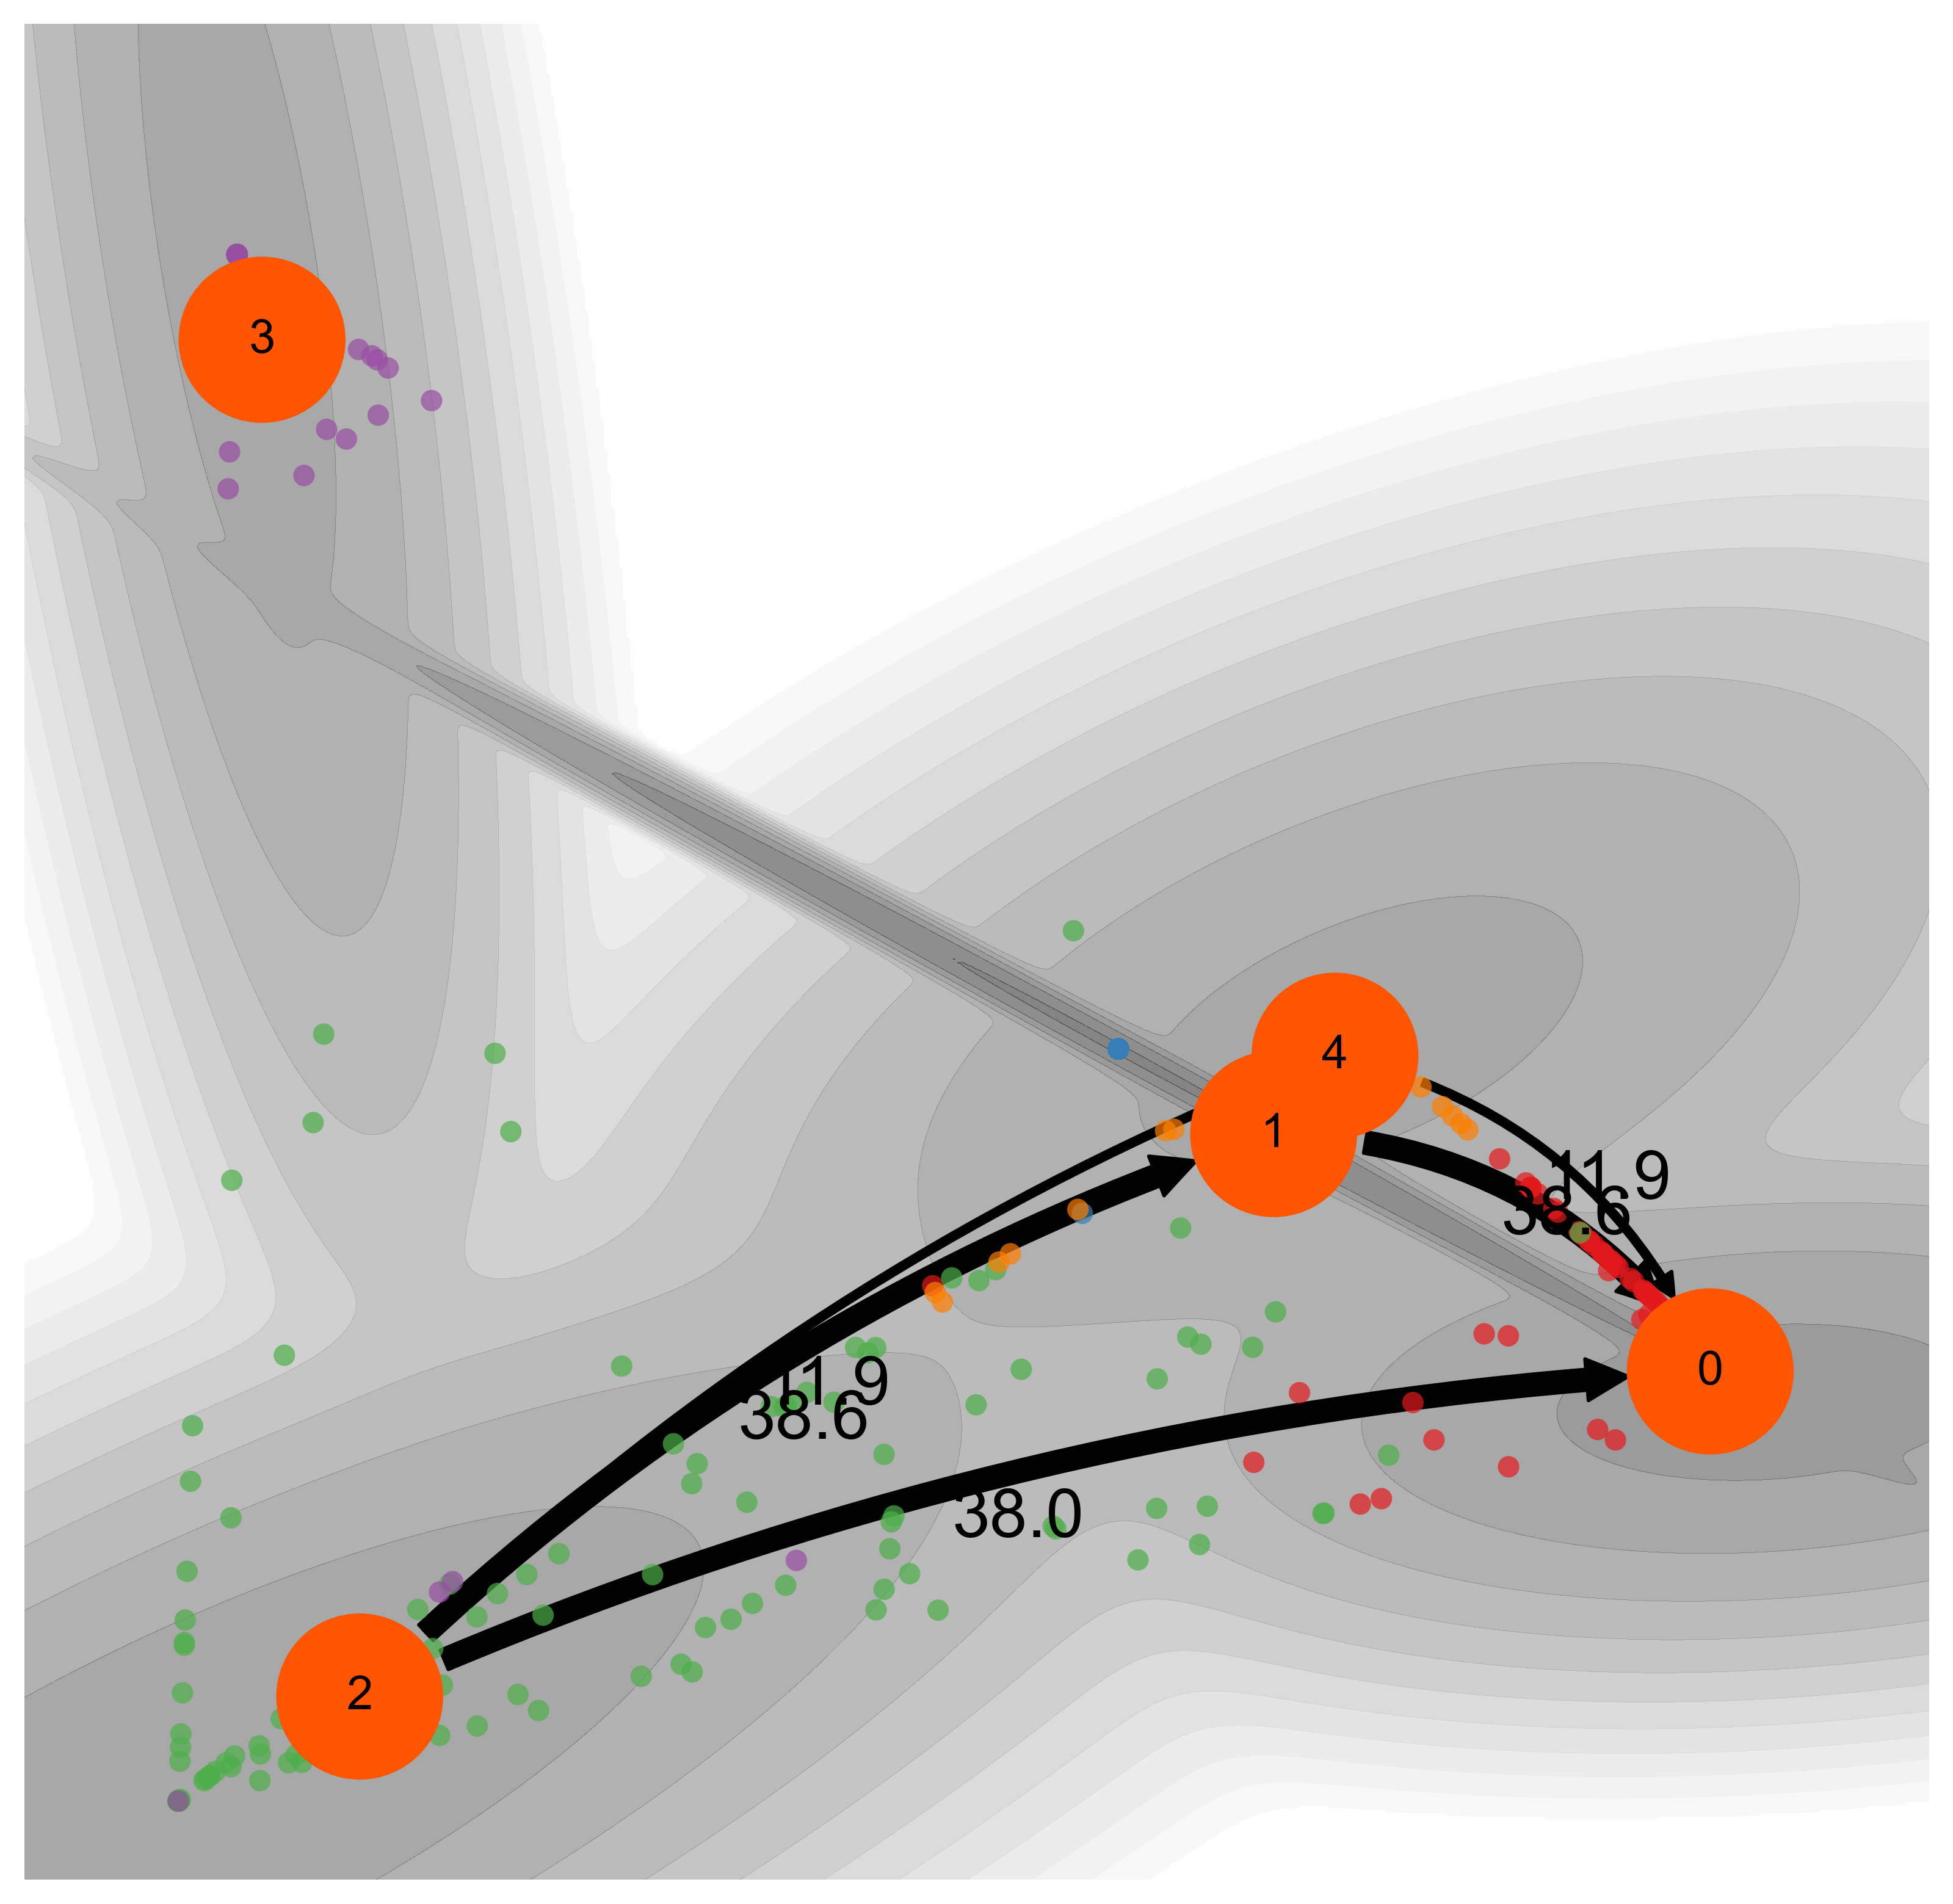

In [23]:
fig = plt.figure(figsize = (10,10))
pm.infer_lineage(adata_meta,si=2,sf = 0,method = "MPPT",flux_fraction = 0.8,size_state = 0.2,size_point =40,size_text=20,alpha_point = 0.7)
fig.savefig('bm_meta_mpft_mono.pdf')